# Exploratory Analysis of YouTube Structured Data

## Importing libraries

In [55]:
import pandas as pd
import numpy as np
import string 
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d

## Creating functions

In [2]:
# get list of deciles from a distribution
def get_decile(dist):
    decile = []
    for nth in np.arange(0, 1, 0.1):
        decile.append(np.quantile(dist, nth))
    return decile

In [3]:
# create dictionary from df as key(category column):value(other column)
def col_to_dict_by_cat(data, group):
    my_dict = {}
    for i in group.unique():
        my_dict[i] = data[group == i]  
    return my_dict

In [4]:
# plots worldclouds where metric is above/below a list (rows) of boundary pairs (columns)
def plot_top_bottom_wordcloud(text, metric, tails, text_name='Text', metric_name='Metric', extra_label=''):

    nrow = len(tails)
    ncol = len(tails[0])

    plt.figure(figsize=(20, nrow*5))
    stitle = 'Most Used Words in '+text_name+'\n'
    plt.suptitle(stitle)
    
    wc = 1
    for r in range(nrow):
        for c in range(ncol):
        
            if (c%2)==0:
                text_list = text[metric>tails[r][c]]
                direction = 'More Than'
            else:
                text_list = text[metric<tails[r][c]]
                direction = 'Less Than'

            if len(text_list) !=0:
                words = ' '.join(text_list)
            else:
                words = 'Na'

            plt.subplot(nrow, ncol, wc)
            wcloud = WordCloud(width=800, height=400,max_words=30).generate(words)
            plt.imshow(wcloud)
            plt.axis('off')
            title = ' '.join([' with', direction, str(round(tails[r][c])), metric_name, extra_label])
            plt.title(title)
            wc += 1

    plt.tight_layout(pad=0.1)
    plt.show()

In [5]:
# plots worldclouds by a categorical variable (rows) where metric is above/below a list of boundary pairs (columns) 
def plot_top_bottom_wordcloud_by_cat(text, category, metric, tails, 
                                     text_name='Text', category_name='Category', metric_name='Metric'):
    
    text_dict = col_to_dict_by_cat(text, category)
    metric_dict = col_to_dict_by_cat(metric, category)

    nrow = len(text_dict.keys())
    ncol = len(tails)

    plt.figure(figsize=(20, nrow*5))
    stitle = 'Most Used Words in '+text_name+' by '+category_name+'\n'
    plt.suptitle(stitle)

    wc = 1
    for k, r in zip(text_dict.keys(), range(nrow)):   
        for t, c in zip(tails, range(ncol)):

            if c==0:
                text_list = text_dict[k][metric_dict[k]>t]
                direction = 'More Than'
            else:
                text_list = text_dict[k][metric_dict[k]<t]
                direction = 'Less Than'

            if len(text_list) !=0:
                words = ' '.join(text_list)
            else:
                words = 'Na'

            plt.subplot(nrow, ncol, wc)
            wcloud = WordCloud(width=800, height=400,max_words=30).generate(words)
            plt.imshow(wcloud)
            plt.axis('off')
            title = ' '.join([' with', direction, str(round(tails[c])), metric_name, 'in the', k.upper(), 'Category'])
            plt.title(title)
            wc +=1

    plt.tight_layout(pad=0.1)
    plt.show()

## Loading pre-processed dataset

In [72]:
vid = pd.read_csv('./videos-with-comments-aggr.csv',  index_col=0)
vid.head()

,id,title,date,tag,views,likes,comments,comment,mean_comment_likes,mean_comment_sentiment,unicode_title,unicode_comment,likes_per_view,comments_per_view,views_above_mean,likes_above_mean,comments_above_mean,days_old
0,wAZZ-UWGVHI,Apple Pay Is Killing the Physical Wallet After...,2022-08-23,tech,135612.0,3407.0,672.0,Let's not forget that Apple Pay in 2014 requir...,39.1,1.2,Apple Pay Is Killing the Physical Wallet After...,Let's not forget that Apple Pay in 2014 requir...,0.025123,0.004955,False,False,False,1
1,b3x28s61q3c,The most EXPENSIVE thing I own.,2022-08-24,tech,1758063.0,76779.0,4306.0,"Wow, you really went to town on the PSU test r...",598.2,1.8,The most EXPENSIVE thing I own.,"Wow, you really went to town on the PSU test r...",0.043672,0.002449,False,False,False,0
2,4mgePWWCAmA,My New House Gaming Setup is SICK!,2022-08-23,tech,1564007.0,63825.0,3338.0,Linus!!! Just turn the key lights 180 and bou...,626.2,1.9,My New House Gaming Setup is SICK!,Linus!!! Just turn the key lights 180 and bou...,0.040809,0.002134,False,False,False,1
3,kXiYSI7H2b0,Petrol Vs Liquid Nitrogen | Freezing Experimen...,2022-08-23,tech,922918.0,71566.0,1426.0,Unstoppable experiments with liquid nitrogen 🎉...,528.8,1.6,Petrol Vs Liquid Nitrogen | Freezing Experimen...,Unstoppable experiments with liquid nitrogen 🎉...,0.077543,0.001545,False,False,False,1
4,ErMwWXQxHp0,Best Back to School Tech 2022!,2022-08-08,tech,1855644.0,96513.0,5155.0,"Guys, a quick note that you do NOT need all th...",2721.7,1.6,Best Back to School Tech 2022!,"Guys, a quick note that you do NOT need all th...",0.052011,0.002778,False,False,False,16


## Distribution of video metrics: Views, Likes, & Comments

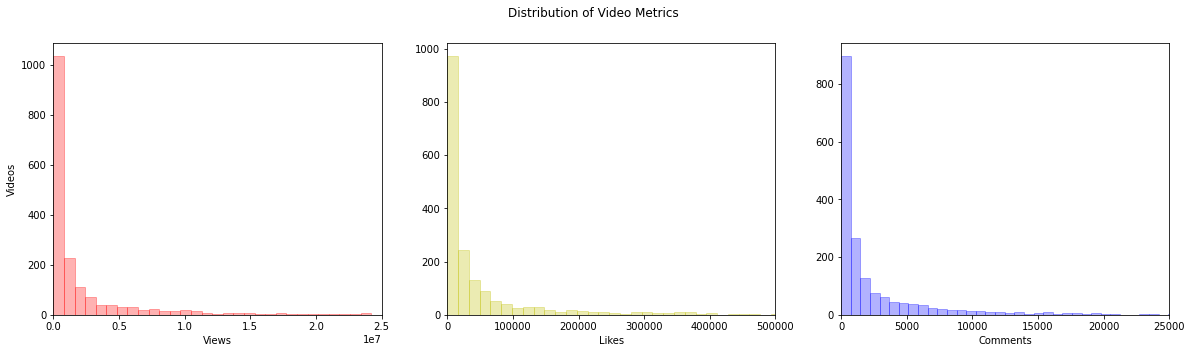

In [42]:
dist = [vid.views, vid.likes, vid.comments]
nbin = [5000, 1000, 1000]
xlim = [[-1,25000000], [-1,500000], [-1,25000]]
color = ['r', 'y', 'b']

fig, ax = plt.subplots(1, len(dist), figsize=(20, 5))
plt.suptitle('Distribution of Video Metrics')
ax[0].set_ylabel('Videos')

for i in range(len(dist)):
    ax[i].hist(dist[i], bins=nbin[i], 
               color=color[i],  alpha=.3, edgecolor=color[i])
    ax[i].set(xlabel=dist[i].name.capitalize(),
              xlim=xlim[i])

plt.show()

In [11]:
vid.describe()

,views,likes,comments,mean_comment_likes,mean_comment_sentiment,likes_per_view,comments_per_view,days_old
count,1.879000e+03,1.879000e+03,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000
mean,1.161292e+07,1.700610e+05,7863.331559,1018.990255,1.490111,0.033560,0.003596,445.813731
std,1.084450e+08,7.962293e+05,37879.964926,5033.903900,0.416193,0.025786,0.006674,813.934794
min,2.500000e+01,-1.000000e+00,-1.000000,0.000000,0.000000,-0.000081,-0.000035,0.000000
25%,8.451500e+04,2.672500e+03,199.000000,16.100000,1.236111,0.015102,0.000673,1.000000
50%,5.917210e+05,1.478700e+04,814.000000,107.100000,1.600000,0.027528,0.001501,70.000000
75%,2.804978e+06,6.090600e+04,3377.500000,663.000000,1.800000,0.044495,0.003730,552.500000
max,4.034122e+09,1.644556e+07,732818.000000,173962.200000,2.000000,0.218575,0.083422,5518.000000


## Correlation between video metrics

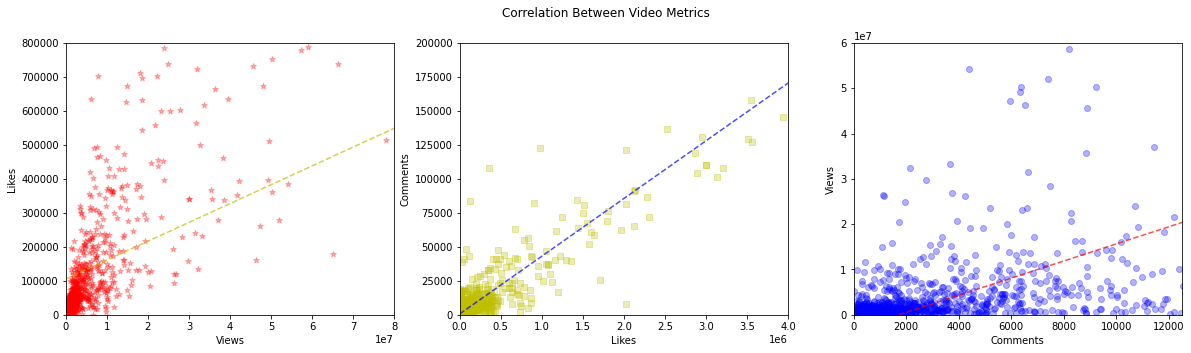

In [52]:
dist = [vid.views, vid.likes, vid.comments, vid.views]
xlim = [[-1,80000000], [-1,4000000], [-1,12500]]
ylim = [[-1,800000], [-1,200000], [-1,60000000]]
mark = ['*', 's', 'o']
color = ['r', 'y', 'b', 'r']

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
plt.suptitle('Correlation Between Video Metrics')

for i in range(3):
    ax[i].scatter(dist[i], dist[i+1], 
                  marker=mark[i], color=color[i], alpha=.3, edgecolor=color[i])
    ax[i].plot(np.unique(dist[i]), np.poly1d(np.polyfit(dist[i], dist[i+1], 1))(np.unique(dist[i])),
               color=color[i+1],  alpha=.7, linestyle='--')
    ax[i].set(xlabel=dist[i].name.capitalize(),
              ylabel=dist[i+1].name.capitalize(),
              xlim=xlim[i],
              ylim=ylim[i])

plt.show()

In [12]:
vid.corr()

,views,likes,comments,mean_comment_likes,mean_comment_sentiment,likes_per_view,comments_per_view,views_above_mean,likes_above_mean,comments_above_mean,days_old
views,1.000000,0.754475,0.659654,0.143051,0.017117,-0.078593,-0.046855,0.280402,0.237093,0.225750,0.146832
likes,0.754475,1.000000,0.892284,0.630059,0.034304,-0.043880,-0.073430,0.500013,0.466315,0.433948,0.153076
comments,0.659654,0.892284,1.000000,0.599072,0.014319,-0.043414,-0.034101,0.444519,0.411593,0.436260,0.138875
mean_comment_likes,0.143051,0.630059,0.599072,1.000000,0.005428,-0.005495,-0.052483,0.331764,0.323223,0.319050,0.079117
mean_comment_sentiment,0.017117,0.034304,0.014319,0.005428,1.000000,0.042876,-0.236026,0.075415,0.086594,-0.014669,0.111349
likes_per_view,-0.078593,-0.043880,-0.043414,-0.005495,0.042876,1.000000,0.328113,-0.175183,-0.045567,-0.064585,-0.267983
comments_per_view,-0.046855,-0.073430,-0.034101,-0.052483,-0.236026,0.328113,1.000000,-0.137237,-0.135597,-0.002989,-0.178521
views_above_mean,0.280402,0.500013,0.444519,0.331764,0.075415,-0.175183,-0.137237,1.000000,0.704857,0.587002,0.299807
likes_above_mean,0.237093,0.466315,0.411593,0.323223,0.086594,-0.045567,-0.135597,0.704857,1.000000,0.678842,0.221732
comments_above_mean,0.225750,0.433948,0.436260,0.319050,-0.014669,-0.064585,-0.002989,0.587002,0.678842,1.000000,0.191424


## Frequency of Video uploads across the Week, Month, Year, & Decade

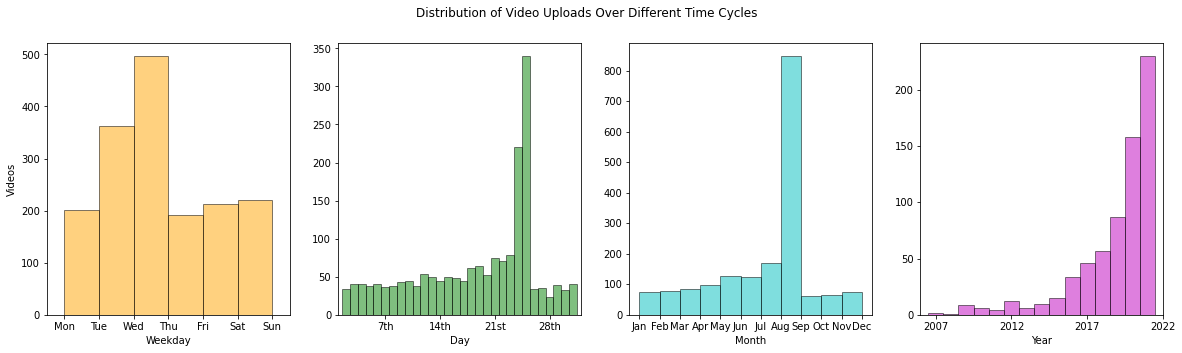

In [63]:
vid.date = pd.to_datetime(vid.date)

dist = [vid.date.dt.weekday, vid.date.dt.day, vid.date.dt.month, vid.date.dt.year]
xlab = ['Weekday', 'Day', 'Month', 'Year']
tlab = [['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 
        ["7th", '14th', '21st', '28th'],
        ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
        ["2007", '2012', '2017', '2022']]
color = ['orange', 'g', 'c', 'm']

fig, ax = plt.subplots(1, len(dist), figsize=(20, 5))
plt.suptitle("Distribution of Video Uploads Over Different Time Cycles")
ax[0].set_ylabel('Videos')

ax[0].set_xticks(np.arange(dist[0].min()-.5, dist[0].max()+.5))
ax[1].set_xticks([6,13,20,27])
ax[2].set_xticks(np.arange(dist[2].min()-.5, dist[2].max()+.5))
ax[3].set_xticks([2007, 2012, 2017, 2022])

for i in range(len(dist)):
    xmin = dist[i].min()
    xmax = dist[i].max()   
    ax[i].hist(dist[i], bins=np.arange(xmin-.5, xmax+.5), 
               color=color[i], alpha=.5, edgecolor='k')
    ax[i].set(xlim=[xmin-1, xmax],
              xlabel=xlab[i],
              xticklabels=tlab[i]) 

plt.show()

## Moving monthly mean of main video metrics

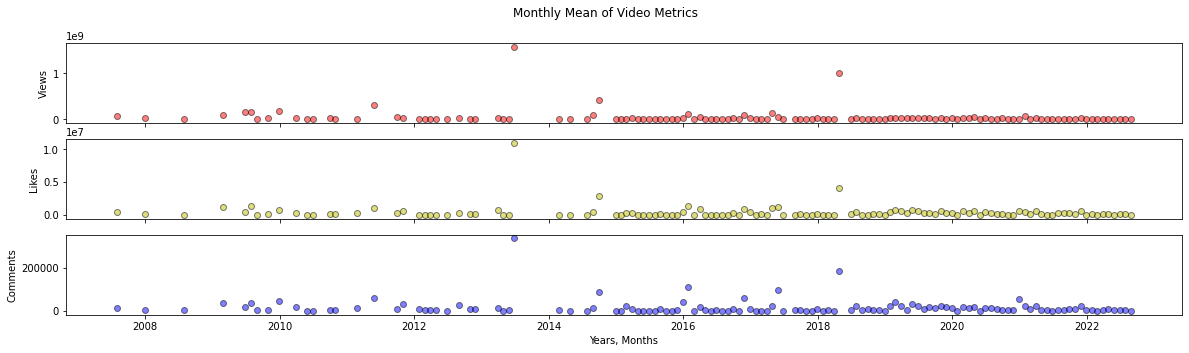

In [66]:
vid_dm_mean = vid.resample('M', on='date').mean()

dist = [vid_dm_mean.views, vid_dm_mean.likes, vid_dm_mean.comments]
ylab = ['Views', 'Likes', 'Comments']
color = ['r', 'y', 'b']

fig, ax = plt.subplots(3, 1, figsize=(20, 5))
plt.suptitle("Monthly Mean of Video Metrics")

for i in range(3):
    ax[i].scatter(dist[i].keys(), dist[i].values, 
                  marker='o', color=color[i], alpha=.5, edgecolor = "k")
    ax[i].set_ylabel(ylab[i])

ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
ax[2].set_xlabel("Years, Months")

plt.show()

## Tag popularity

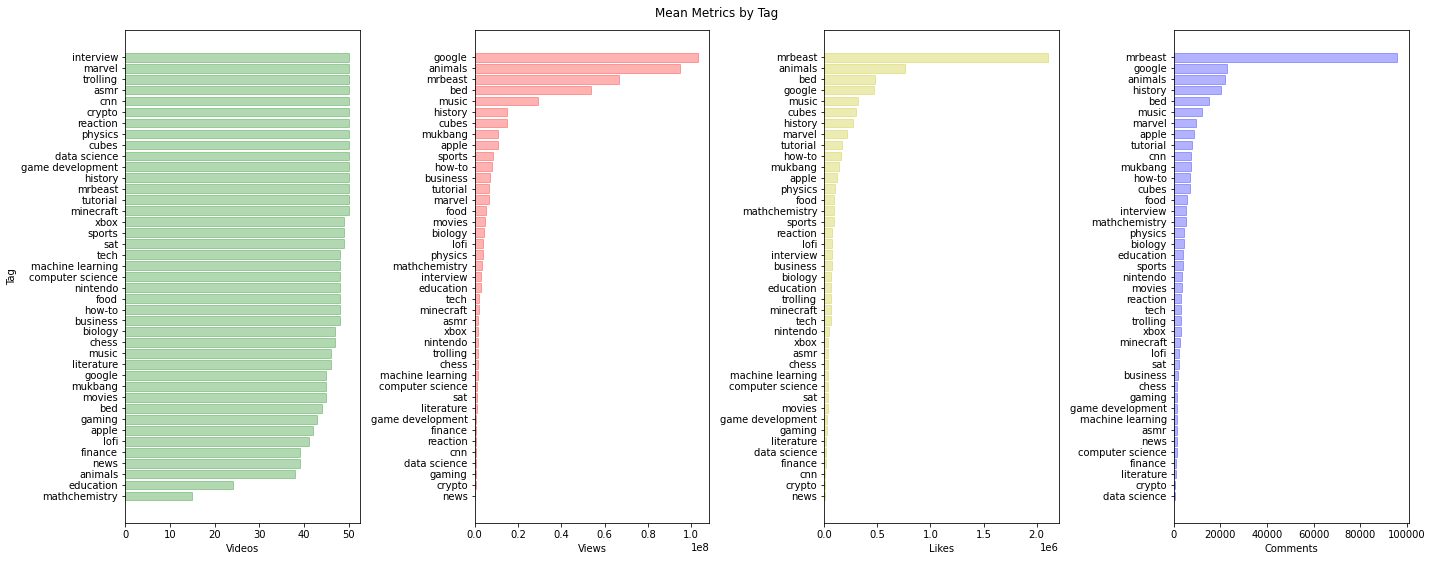

In [76]:
vid_by_tag = vid.groupby('tag')

dist = [vid_by_tag.size().sort_values(), vid_by_tag.mean().views.sort_values(), 
        vid_by_tag.mean().likes.sort_values(), vid_by_tag.mean().comments.sort_values()]
xlab = ['Videos', 'Views', 'Likes', 'Comments']
color = ['g', 'r', 'y', 'b']

fig, ax = plt.subplots(1, 4, figsize=(20, 7.9))
plt.suptitle("Mean Metrics by Tag")

for i in range(4):
    ax[i].barh(dist[i].keys(), dist[i].values, 
               color=color[i], alpha=.3, edgecolor=color[i])
    ax[i].set_xlabel(xlab[i])

ax[0].set_ylabel("Tag")

fig.tight_layout()

plt.show()

## Videos with above-mean metrics

In [16]:
vid.groupby('likes_above_mean').describe()

views                                                    \
                   count          mean           std        min        25%   
likes_above_mean                                                             
False             1632.0  1.612912e+06  6.673732e+06       25.0    64833.5   
True               247.0  7.768582e+07  2.905820e+08  1223879.0  8760266.5   

                                                          likes                \
                         50%          75%           max   count          mean   
likes_above_mean                                                                
False               379606.0   1453639.25  2.392072e+08  1632.0  2.565325e+04   
True              19097087.0  58756288.50  4.034122e+09   247.0  1.124205e+06   

                  ... comments_per_view           days_old              \
                  ...               75%       max    count        mean   
likes_above_mean  ...                                                    
False             ...          0.004162  0.083422   1632.0  375.621324   
True              ...          0.001595  0.013204    247.0  909.595142   

                                                                   
                          std  min    25%    50%      75%     max  
likes_above_mean                                                   
False              738.201619  0.0    1.0   35.0   383.75  5370.0  
True              1093.564503  0.0  125.0  585.0  1181.00  5518.0  

[2 rows x 64 columns]

In [17]:
vid.groupby('views_above_mean').describe()

views                                                       \
                   count          mean           std         min          25%   
views_above_mean                                                                
False             1691.0  1.476542e+06  2.376665e+06        25.0     67531.50   
True               188.0  1.027864e+08  3.298016e+08  11666184.0  18081532.75   

                                                          likes                \
                         50%          75%           max   count          mean   
views_above_mean                                                                
False               425073.0   1662752.50  1.156327e+07  1691.0  3.734874e+04   
True              34131881.0  84941698.25  4.034122e+09   188.0  1.363766e+06   

                  ... comments_per_view           days_old               \
                  ...               75%       max    count         mean   
views_above_mean  ...                                                     
False             ...          0.004106  0.083422   1691.0   364.470136   
True              ...          0.001098  0.006237    188.0  1177.473404   

                                                                   
                          std  min     25%    50%     75%     max  
views_above_mean                                                   
False              697.275403  0.0    1.00   39.0   386.0  5143.0  
True              1288.906901  0.0  271.25  801.0  1366.5  5518.0  

[2 rows x 64 columns]

In [18]:
vid.groupby('comments_above_mean').describe()

views                                                   \
                      count          mean           std       min        25%   
comments_above_mean                                                            
False                1627.0  1.980674e+06  5.757293e+06      25.0    64549.0   
True                  252.0  7.380204e+07  2.886044e+08  264809.0  5191376.0   

                                                            likes  \
                            50%         75%           max   count   
comments_above_mean                                                 
False                  377483.0   1546191.5  1.229945e+08  1627.0   
True                 14508430.5  55279615.5  4.034122e+09   252.0   

                                   ... comments_per_view           days_old  \
                             mean  ...               75%       max    count   
comments_above_mean                ...                                        
False                3.411480e+04  ...          0.003799  0.083422   1627.0   
True                 1.047777e+06  ...          0.003307  0.045486    252.0   

                                                                                
                           mean          std  min   25%    50%     75%     max  
comments_above_mean                                                             
False                384.511371   746.221105  0.0   1.0   42.0   412.5  5370.0  
True                 841.603175  1080.678904  0.0  62.0  508.5  1133.5  5518.0  

[2 rows x 64 columns]